In [76]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import scipy.optimize as optimize
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing

import shutil
import sys
import os.path

In [ ]:
The data:

In [3]:
climate_data = np.array([[120., 4.835], [210., 15.405], [270., 8.315]
                         , [375., -0.73], [480.,  5.08], [570., 14.945]
                         , [630., 8.58], [735., 1.38], [840., 6.37]
                         , [930., 16.015], [990., 8.065], [1095., 0.29]
                         , [1200.,4.435], [1290., 15.885], [1350., 8.26]
                         , [1455., 0.69], [1560., 2.43], [1650., 14.77]
                         , [1710., 7.795], [1815., 0.56], [1920., 4.17]
                         , [2010., 14.325], [2070., 8.11], [2175., 0.135]
                         , [2280., 6.195], [2370., 14.495], [2430., 8.46]
                         , [2535., -4.24], [2640., 4.335], [2730., 15.35], [2790., 7.1]
                         ])

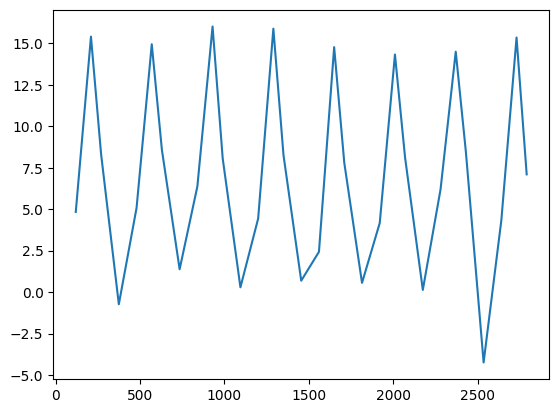

In [4]:
plt.plot(climate_data[:,0], climate_data[:,1])

Select the model

In [20]:
def residuals(parameters, climate_data):
    beta0, beta1, a = parameters
    x = climate_data[:,0] # time
    y = climate_data[:,1] # temperature
    return y - (beta0 + beta1 * np.sin(2 * np.pi * x / 365.25 - a))

Find a best fit

In [33]:
def sos(parameters, climate_data):
    return np.sum(residuals(parameters, climate_data)**2)

def best_fit(fcn, climate_data, disp=1):
    parameter_guess = np.array([6.91, -7.93, -8.07])
    return optimize.fmin(fcn, parameter_guess, args=(climate_data,), disp = disp)

parameter_fit = best_fit(sos, climate_data)

for name,value in zip(['beta0', 'beta1', 'a'], parameter_fit):
    print(name, " = ",  round(value,2))

Optimization terminated successfully.
         Current function value: 145.553338
         Iterations: 62
         Function evaluations: 117
beta0  =  5.89
beta1  =  -7.31
a  =  -7.68


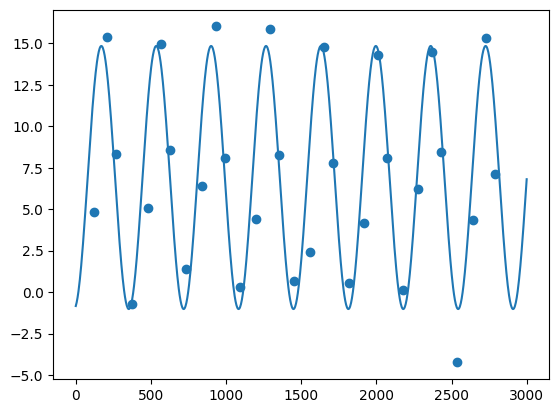

In [28]:
beta0  =  6.91
beta1  =  -7.93
a  =  -8.07
t = np.linspace(0, 3000, 1000)
plt.plot(t,(beta0 + beta1 * np.sin(2 * np.pi * t / 365.25 - a)))
plt.scatter(climate_data[:,0], climate_data[:,1])
pl.show()

Testing the fitting process with a SIR model and synthetic data generated by Mathematica.

In [103]:

data = np.array([1.19646, 1.43109, 1.71112, 2.04506, 2.44293, 2.91644, 3.47919, 
                 4.14694, 4.93776, 5.87222, 6.9734, 8.26688, 9.78045, 11.5436, 
                 13.5864, 15.9384, 18.6265, 21.672, 25.0875, 28.8727, 33.0102, 
                 37.4611, 42.1613, 47.0193, 51.917, 56.7128, 61.2487, 65.3608, 
                 68.8917, 71.7039, 73.6916, 74.7898, 74.9782, 74.2812, 72.7626, 
                 70.5173, 67.6618, 64.3231, 60.6301, 56.7058, 52.6616, 48.5941, 
                 44.5836, 40.6936, 36.9722, 33.4535, 30.1593, 27.1016, 24.284, 21.7042]
                )

#   Define the model 
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = - beta * I * (S / ((S+I+R)*1.0))
    dI_dt = beta * I * (S / ((S+I+R)*1.0))  - gamma * I
    dR_dt = gamma * I
    return ([dS_dt, dI_dt, dR_dt])

#Define the objective function to minimize (sum of squared errors)
def objectiveFunction(parameters, *args):
    beta , gamma = parameters
    y_obseved, time, initial_conditions = args
    solution = scipy.odeint(SIR_model, initial_conditions, time, args =(beta,gamma))
    y_predicted = solution[:,1] #only need the infected
    error = np.sum((y_predicted - y_obseved)**2)
    return error
    
# Set up the data and initial conditions
t = np.linspace(0, len(data)) # assume one time step per day
initial_conditions = [999, 1, 0] # 999 susceptible, 1 infected, 0 recovered
y_obseved = data # the data we are trying to fit


# Choose initial guesses for the parameters to fit
beta_guess = 0.05
gamma_guess = 0.7

# Minimize the objective function to obtain estimates for beta and gamma
result = optimize.minimize(objectiveFunction, [beta_guess, gamma_guess], args=(y_obseved,t, initial_conditions), method='L-BFGS-B', bounds=[(0, 2), (0, 2)])
beta_estimated, gamma_estimated = result.x

print("beta = ", beta_estimated)
print("gamma = ", gamma_estimated)

beta =  0.5033297068053009
gamma =  0.3210057864796298


In [73]:
t = np.linspace(0, 10, 10)

def sos(beta, totalDeaths):
    modelOutput = scipy.odeint(SIRD_model, [S0,I0,R0,D0], t, args=(N, gamma, mu, beta))
    firstOutput = modelOutput[1]
    firstDeath = firstOutput[-1]#first position when there is a death
    lastOutput = modelOutput[-1]
    modelDeaths = lastOutput[-1]
    return ((modelDeaths-totalDeaths)**2 + (firstDeath - 1.0)**2)

def best_fit(fcn, totalDeaths):
    beta_guess = 0.7
    return optimize.fmin(fcn, beta_guess, args=(totalDeaths,))


#parameter_fit = best_fit(sos, totalDeaths=60)

#for name,value in zip(['beta'], parameter_fit):
    #print(name, " = ",  round(value,2))

In [85]:


def loss_function(beta, t, cumDeathsData):
    t = np.linspace(0, 20, 20)
    modelOutput = scipy.odeint(SIRD_model, [S0,I0,R0,D0], t, N, beta, gamma, mu)
    
    loss =0.0

    for i in range(len(cumDeathsData)):
        modelDeaths = modelOutput[i,3]
        data_deaths = cumDeathsData[i]
        res = (modelDeaths - data_deaths)**2
        loss += res
    return(loss)

beta0 = 0.3
minimum = optimize.fmin(loss_function, beta0, args=(t,cumDeathsData) )
print(minimum)

TypeError: 'float' object cannot be interpreted as an integer

Defining the transmission rate as a seasonality function

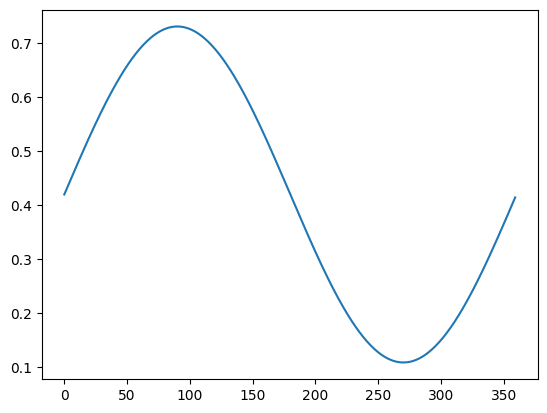

In [ ]:

def seasonal_transmission_rate(beta_0, beta_1, frequency,a, t):
    beta_t = beta_0 * (1 + beta_1 * np.sin((2 * np.pi)* frequency * t))
    return beta_t

# Generate some example data with seasonality
t = np.arange(0, 360)
beta_0 = 0.42
beta_1 = 0.74

# Plot beta 
plt.plot(t, seasonal_transmission_rate(beta_0, beta_1, 1/(360*1.0),-1.2, t))
plt.show()



In [ ]:
#Deaths by parish. Zero means we don't have information
TotalDeathsByParish = 1.0*np.array([0,40,740,0,80,60,0,0,38,70,0,0,45,0,0,0,270,45,0])
#initial day for each parish
BeginPlagueByParish = 1.0*np.array([1,61,61,91,91,91,91,121,121,121,121,121,121,121,151,181,271,331,511])
#final day for each parish. Zero means we don't have information
EndPlagueByParish = 1.0*np.array([60#Bromma
                              ,360#Oja
                              ,270#Ystad
                              ,0#Valleberga
                              ,300#Kopinge
                              ,0#Horups
					          ,0#Bjaresjo
                              ,150#Villie
                              ,510#Snarestad
                              ,270#Skarby
                              ,0#Hammenhogs
					          ,150#Glemminge
                              ,240#Balkakra
                              ,0#Baldringe
                              ,180#Ovraby
                              ,270#Sovestads
					          ,570#Loderups
                              ,570#Borrby
                              ,570#Tosterups
                              ])
print(BeginPlagueByParish[-1])
max(EndPlagueByParish)

511.0


570.0